In [205]:
import pandas as pd

df = pd.read_csv('data.csv')

In [206]:
# Remove rows with missing values
df.dropna(inplace=True)
# Drop the TractId column as it is not needed
df.drop(['TractId'], axis=1, inplace=True)
df.drop(['County'], axis=1, inplace=True)

In [207]:
# Encode strings to integers
from sklearn.preprocessing import LabelEncoder
df = df.apply(LabelEncoder().fit_transform)

print(df.head(10))

   State  TotalPop   Men  Women  Hispanic  White  Black  Native  Asian  \
0      0      1192   673    745        24    863     52       0     12   
1      0      1519   941    804        11    416    545       0     10   
2      0      2732  1307   1651        80    614    265       6      7   
3      0      3614  1775   2065        96    803     71       5      2   
4      0      8670  4689   4624         9    775    164       0     31   
5      0      2967  1539   1654        30    707    251       0      0   
6      0      2767  1233   1760        40    780    137       6      0   
7      0      2260  1269   1217        42    863     71      15      0   
8      0      9101  4930   5154        14    818    153       0     10   
9      0      5514  2885   2855        10    862     97       8      3   

   Pacific  ...  Walk  OtherTransp  WorkAtHome  MeanCommute  Employed  \
0        0  ...     5            0          21          189       781   
1        0  ...     0            5     

In [208]:
# Divide the rows into 4 groups, with equal number of rows in each group based on the values in the column 'ChildPoverty'. And encode the child poverty value to either be 0, 1, 2, or 3.
df['ChildPoverty'] = pd.qcut(df['ChildPoverty'], 4, labels=False)
print(df.head(10))

   State  TotalPop   Men  Women  Hispanic  White  Black  Native  Asian  \
0      0      1192   673    745        24    863     52       0     12   
1      0      1519   941    804        11    416    545       0     10   
2      0      2732  1307   1651        80    614    265       6      7   
3      0      3614  1775   2065        96    803     71       5      2   
4      0      8670  4689   4624         9    775    164       0     31   
5      0      2967  1539   1654        30    707    251       0      0   
6      0      2767  1233   1760        40    780    137       6      0   
7      0      2260  1269   1217        42    863     71      15      0   
8      0      9101  4930   5154        14    818    153       0     10   
9      0      5514  2885   2855        10    862     97       8      3   

   Pacific  ...  Walk  OtherTransp  WorkAtHome  MeanCommute  Employed  \
0        0  ...     5            0          21          189       781   
1        0  ...     0            5     

In [209]:
print(len(df.loc[df['ChildPoverty'] == 0]))
print(len(df.loc[df['ChildPoverty'] == 1]))
print(len(df.loc[df['ChildPoverty'] == 2]))
print(len(df.loc[df['ChildPoverty'] == 3]))
print(len(df.loc[df['ChildPoverty'] == 4]))

18229
18171
18148
18170
0


In [210]:
# Split the data into features and labels
X = df.drop(['ChildPoverty'], axis=1)
y = df['ChildPoverty']

# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train_frame, X_test_frame, y_train_frame, y_test_frame = \
    train_test_split(X_norm, y, test_size=0.2, random_state=1)

# Convert the dataframes to numpy arrays
X_train = X_train_frame
X_test = X_test_frame
y_train = y_train_frame
y_test = y_test_frame

In [211]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(58174, 34)
(14544, 34)
(58174,)
(14544,)


In [212]:
# Create the model

import numpy as np
from scipy.special import expit
import sys
import pandas as pd

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
# Start with the following functions:
#    init
#    encode_labels
#    initialize weights
#    sigmoid
#    add bias (vector of ones)
#    objective function (cost and regularizer)
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_) # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))
        
        W2_num_elems = (self.n_hidden)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden)
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1 ** 2) + np.mean(W2 ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    

In [213]:
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C * 2
        gradW2 += W2 * self.l2_C * 2 

        return gradW1, gradW2, gradb1, gradb2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2, self.b1, self.b2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * gradW1
            self.W2 -= self.eta * gradW2
            self.b1 -= self.eta * gradb1
            self.b2 -= self.eta * gradb2
            

        return self

In [214]:
from sklearn.metrics import accuracy_score

params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=400, # iterations
              eta=0.001,  # learning rate
              random_state=1)

nn = TwoLayerPerceptron(**params)

nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))


Epoch: 400/400

Accuracy: 0.3140814081408141


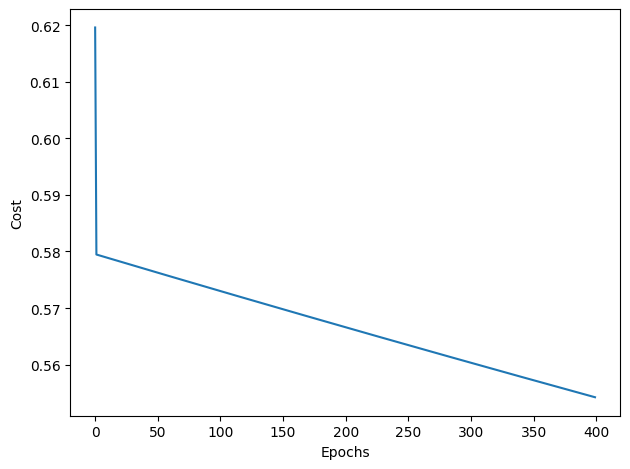

In [215]:
from matplotlib import pyplot as plt

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [216]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)


In [217]:
from sklearn.metrics import accuracy_score

params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=400, # iterations
              eta=0.001,  # learning rate
              random_state=1)

nn = TwoLayerPerceptron(**params)

nn.fit(X_train_norm, y_train, print_progress=50)
yhat = nn.predict(X_test_norm)
print('Accuracy:',accuracy_score(y_test,yhat))

Epoch: 400/400

Accuracy: 0.3169004400440044


In [218]:
# Use one hot encoding for the labels

In [219]:
# Print the column names
print(X.columns)

Index(['State', 'TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black',
       'Native', 'Asian', 'Pacific', 'VotingAgeCitizen', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'Professional', 'Service',
       'Office', 'Construction', 'Production', 'Drive', 'Carpool', 'Transit',
       'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Employed',
       'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork',
       'Unemployment'],
      dtype='object')


In [220]:
# One hot encode the labels
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)


In [221]:
encode_and_bind(X, 'State')

# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)


In [222]:
from sklearn.model_selection import train_test_split

X_train_frame, X_test_frame, y_train_frame, y_test_frame = \
    train_test_split(X_norm, y, test_size=0.2, random_state=1)

# Convert the dataframes to numpy arrays
X_train = X_train_frame
X_test = X_test_frame
y_train = y_train_frame
y_test = y_test_frame
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(58174, 34)
(14544, 34)
(58174,)
(14544,)


In [223]:
from sklearn.metrics import accuracy_score

params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=400, # iterations
              eta=0.001,  # learning rate
              random_state=1)

nn = TwoLayerPerceptron(**params)

nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))



Epoch: 400/400

Accuracy: 0.3140814081408141


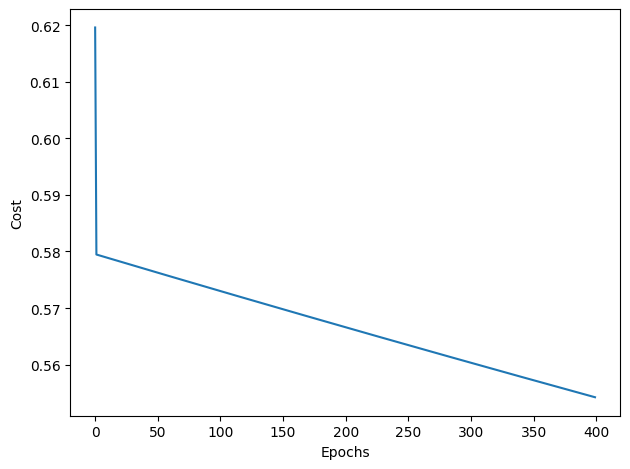

In [224]:
from matplotlib import pyplot as plt

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [225]:
# Try with scikit
from sklearn.neural_network import MLPClassifier
params = dict(hidden_layer_sizes=(30), 
              alpha=0.1, # tradeoff L2 regularizer
              max_iter=400, # iterations
              learning_rate_init=0.001,  # learning rate
              random_state=1)

nn = MLPClassifier(**params)

nn.fit(X_train, y_train)

yhat = nn.predict(X_test)

print('Accuracy:',accuracy_score(y_test,yhat))

Accuracy: 0.7418179317931793


In [226]:
print(X_train[0])

[ 1.3017512   0.37756428  0.06435835  0.63407181  0.63753587 -1.85573584
  2.29114991 -0.22661465 -0.50920366 -0.17967672 -0.3544377  -1.41844605
 -1.38862083 -1.26923601 -1.03349081  1.33578704 -1.44000958  2.35588601
 -0.28888303  0.70354925  0.06325437  0.36225803 -0.18113726 -0.06609842
 -0.45028719  0.09023218 -0.43457759  0.0170304   0.31240149  0.41449322
 -0.24500979 -0.38757705 -0.38837095  1.53613322]
